In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Loading data

In [2]:
from coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from image_utils import image_from_url


In [3]:
data = load_coco_data(pca_features=False)

In [4]:
def show_image(batch_size):
    captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
    for i, (caption, url) in enumerate(zip(captions, urls)):
        plt.imshow(image_from_url(url))
        plt.axis('off')
        caption_str = decode_captions(caption, data['idx_to_word'])
        plt.title(caption_str)
        plt.show()    

In [5]:
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

idx_to_word <class 'list'> 1004
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
word_embedding <class 'numpy.ndarray'> (1004, 304) float64
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63
val_captions <class 'numpy.ndarray'> (195954, 17) int32
word_to_idx <class 'dict'> 1004
train_features <class 'numpy.ndarray'> (82783, 4096) float32
val_features <class 'numpy.ndarray'> (40504, 4096) float32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32


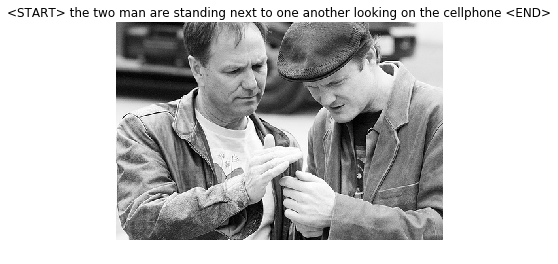

In [6]:
show_image(1)

In [17]:
def group_image_index_by_image_id(image_ids_in_caption_data_order):
    """
        Group image index, which is the same index position as corresponding caption data, by image id.
        i.e {8731 : [0,60,99,305]} caption and image features at these 4 positions correspond to image id 8731
    """
    image_positions_by_image_id = {}
    for i, img_id in enumerate(image_ids_in_caption_data_order):
        if img_id in image_positions_by_image_id:
            image_positions_by_image_id[img_id].append(i)
        else:
            image_positions_by_image_id[img_id] = [i]
    return image_positions_by_image_id

def map_image_index_to_captions(caption_data, grouped_image_index):
    """
        For each image id "key", get its corresponding captions, retrieved by "value" of the image instance indices.
        Image instance indices is assumed to be in the same order as the caption data.
    """
    captions_by_image_id = {}
    for k, v in grouped_image_index.items():
        captions_by_image_id[k] = caption_data[v]
    return captions_by_image_id

def scramble_image_caption_pairs(caption_data, grouped_image_index):    
    to_shuffle_caption = np.copy(caption_data)
    np.random.shuffle(to_shuffle_caption)
    return map_image_index_to_captions(to_shuffle_caption, grouped_image_index)

def flatten_image_caption_groups(grouped_captions):
    all_captions = []
    all_image_ids = []
    for k, v in grouped_captions.items():
        all_image_ids += [k] * len(v) # duplicate lables
        all_captions.append(v)
    flat_image_ids = np.array(all_image_ids)
    flat_captions = np.concatenate(all_captions, axis=0)
    assert flat_image_ids.shape[0] == flat_captions.shape[0]
    return flat_image_ids, flat_captions

def merge_demo_sampled(demo_image, demo_caption, sample_image, sample_caption):
    is_demo = np.ones(demo_image.shape)
    is_sample = np.ones(sample_image.shape) * -1
    return np.concatenate([demo_image, sample_image], axis=0), np.concatenate([demo_caption, sample_caption], axis=0), np.concatenate([is_demo, is_sample], axis=0)

def remove_start_token(captions_with_start_token):
    return np.array([c[1:] for c in captions_with_start_token])


In [18]:
# minibatch
class MiniBatcher(object):
    def __init__(self, batchable_tuple):
        shapes = [b.shape[0] for b in batchable_tuple]
        assert all([s == shapes[0] for s in shapes]), "Data to be batched together should have the same first dimension"
        self.batchable_tuple = batchable_tuple
        self.data_size = shapes[0]
    
    def sample(self, batch_size=100):
        assert batch_size <= self.data_size
        mask = np.random.choice(self.data_size, batch_size)
        batch_list = [b[mask] for b in self.batchable_tuple]
        return tuple(batch_list)

In [19]:
image_ids = data['train_image_idxs']
captions = data['train_captions']
idx_to_word = data['idx_to_word']

# create random pairing
grouped_image_index = group_image_index_by_image_id(image_ids)
grouped_captions = map_image_index_to_captions(captions, grouped_image_index)
scrambled_captions = scramble_image_caption_pairs(captions, grouped_image_index)

# merge both, and retain flag
image_idx_demo, captions_demo = flatten_image_caption_groups(grouped_captions)
image_idx_sampled, caption_sampled = flatten_image_caption_groups(scrambled_captions)

demo_batcher = MiniBatcher((image_idx_demo, captions_demo, np.ones(image_idx_demo.shape)))
sample_batcher = MiniBatcher((image_idx_sampled, caption_sampled, np.ones(image_idx_sampled.shape) * -1))

In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
import layer_utils 

## Model Param

In [ ]:

## word preprocess
vocab_dim = len(data['word_to_idx'])
image_feature_dim = data['val_features'].shape[1]
enable_preprocessed_embedding = True

if enable_preprocessed_embedding:
    word_embedding_dim = data['word_embedding'].shape[1]
else:
    word_embedding_dim = 256

START_TOKEN = '<START>'
END_TOKEN = '<END>'
NULL_TOKEN = '<NULL>'
UNK_TOKEN = '<UNK>'
NULL_ID = data['word_to_idx'][NULL_TOKEN]
START_ID = data['word_to_idx'][START_TOKEN]
END_ID = data['word_to_idx'][END_TOKEN]
UNK_ID = data['word_to_idx'][UNK_TOKEN]

## model params
hidden_dim = 512
learning_rate = 1e-3

print("Vocab Dim: %i\nImage Feature Dim: %i\nWord Embedding Dim: %i"%(vocab_dim, image_feature_dim, word_embedding_dim))

## Model Architecture

In [ ]:
# Word Input


sy_caption_input = tf.placeholder(shape=[None, None], name="caption_input", dtype=tf.int32)

if enable_preprocessed_embedding:
    embedding_init = tf.constant(data['word_embedding'], dtype=tf.float32)
    embedding = tf.get_variable("embedding", initializer=embedding_init)
else:
    embedding_init = tf.random_normal_initializer()
    embedding = tf.get_variable("embedding", [vocab_dim, word_embedding_dim], dtype=tf.float32, initializer=embedding_init)

word_embedding = tf.nn.embedding_lookup(embedding, sy_caption_input)

# Image Input
sy_image_feat_input = tf.placeholder(shape=[None, image_feature_dim], name="image_feat_input", dtype=tf.float32)
image_projection = layer_utils.affine_transform(sy_image_feat_input, hidden_dim, 'image_proj')
initial_cell_state = image_projection * 0

# LSTM states
sy_hidden_state = tf.placeholder(shape=[None, hidden_dim], name="hidden_lstm_state", dtype=tf.float32)
sy_cell_state = tf.placeholder(shape=[None, hidden_dim], name="cell_lstm_state", dtype=tf.float32)

sy_is_initial_step = tf.placeholder(tf.int32, shape=[], name="is_initial_step")

initial_lstm_state = tf.nn.rnn_cell.LSTMStateTuple(image_projection * 0, image_projection)

In [ ]:
# LSTM

use_bidirectional = False
if use_bidirectional:
    cell_fw = tf.nn.rnn_cell.LSTMCell(hidden_dim)
    cell_bw = tf.nn.rnn_cell.LSTMCell(hidden_dim)
    bi_output, _ = tf.nn.bidirectional_dynamic_rnn(cell_fw, cell_bw, word_embedding, initial_state_bw=initial_lstm_state, initial_state_fw=initial_lstm_state, time_major=False, dtype=tf.float32)
    lstm_output = tf.concat([bi_output[0], bi_output[1]], axis=2)
else:
    cell = tf.nn.rnn_cell.LSTMCell(hidden_dim)
    lstm_output, output_cell_state = tf.nn.dynamic_rnn(cell, word_embedding, time_major=False, dtype=tf.float32, initial_state=initial_lstm_state)

incremental_change = layer_utils.difference_over_time(lstm_output, "incremental_change")
hidden_to_reward = tf.squeeze(layer_utils.affine_transform(incremental_change, 1, 'hidden_to_reward'), axis=2)
# hidden_to_reward = tf.squeeze(layer_utils.build_mlp(lstm_output, 1, 'hidden_to_reward', activation=tf.nn.relu), axis=2)


# Apply not-null mask to ignore reward on trailing padding
sy_not_null_mask = tf.placeholder(shape=[None, None], name="mask_not_null", dtype=tf.bool)
sy_is_demo = tf.placeholder(shape=[None], name="is_demo", dtype=tf.float32)
expanded_is_demo = tf.expand_dims(sy_is_demo, dim=1)
numeric_mask_not_null = tf.cast(sy_not_null_mask, dtype=tf.float32)
masked_reward = hidden_to_reward * numeric_mask_not_null
negated_sample_reward = expanded_is_demo * masked_reward # the higher reward to demo, the lower reward to sampled
total_not_null = tf.cast(tf.reduce_sum(numeric_mask_not_null, axis=1), tf.float32)
mean_reward_for_each_sentence = tf.reduce_sum(negated_sample_reward, axis=1) / total_not_null
mean_reward = tf.reduce_mean(mean_reward_for_each_sentence)

update_op = tf.train.AdamOptimizer(learning_rate).minimize(mean_reward * -1) # maximize the reward

print("-- Input tensors --")
print("word embedding shape: ", word_embedding)
# print("bidiretional output layer: ", bi_output)
print("lstm_output output: ", lstm_output)
print("hidden reward: ", hidden_to_reward)

print("\n-- Loss tensors --")
print("Mask not null: ", numeric_mask_not_null)
print("Is demo null: ", sy_is_demo)
print("Total not null: ", total_not_null)
print("Masked reward: ", masked_reward)
print("Negated sample reward: ", masked_reward)
print("Mean reward for each sentence: ", masked_reward)
print("Mean reward: ",  mean_reward)


## Training

In [ ]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [ ]:
def get_image_features(image_ids):
    return data['train_features'][image_ids]

def process_mini_batch(batcher1, batcher2, batch_size):
    image_idx_batch1, caption_batch1, demo_or_sampled_batch1 = batcher1.sample(batch_size)
    image_idx_batch2, caption_batch2, demo_or_sampled_batch2 = batcher2.sample(batch_size)
    image_idx_batch = np.concatenate([image_idx_batch1, image_idx_batch2], axis=0)
    caption_batch = np.concatenate([caption_batch1, caption_batch2], axis=0)
    demo_or_sampled_batch = np.concatenate([demo_or_sampled_batch1, demo_or_sampled_batch2], axis=0)
    not_null_mask_batch = caption_batch != NULL_ID
    # to randomize here
    
    return image_idx_batch, caption_batch, not_null_mask_batch, demo_or_sampled_batch

iter_num = 100
batch_size = 1000
for i in range(iter_num):
    
    image_idx_batch, caption_batch, not_null_mask, demo_or_sampled_batch = process_mini_batch(
        demo_batcher, 
        sample_batcher,
        batch_size
    )
    image_feats_batch = get_image_features(image_idx_batch)

    _, r, m, me = sess.run([update_op, mean_reward, negated_sample_reward, mean_reward_for_each_sentence], feed_dict=
                       {sy_image_feat_input: image_feats_batch,
                        sy_caption_input: caption_batch, 
                        sy_not_null_mask: not_null_mask,
                        sy_is_demo: demo_or_sampled_batch
                       })
    if i % 20 == 0:
        print("iter {}, reward: {}".format(i,r))

In [ ]:
demo_or_sampled_batch[846], decode_captions(caption_batch[846], idx_to_word), 

In [ ]:
def test_run(img_feature_test, caption_test):
    not_null_mask_test = caption_test != NULL_ID
    m = sess.run(masked_reward, feed_dict=
                   {sy_image_feat_input: img_feature_test,
                    sy_caption_input: caption_test, 
                    sy_not_null_mask: not_null_mask_test})
    sum_not_null = np.sum(not_null_mask_test, axis=1)
    me = np.sum(m, axis=1) / sum_not_null
    return m, me
                           
def convert_to_word_ids(captions):
    max_len = max([len(c) for c in captions])
    caption_ids = np.ones((len(captions), max_len), dtype=np.int) * NULL_ID
    for i, c in enumerate(captions):
        for j, tk in enumerate(c):
            if tk in data['word_to_idx']:
                caption_ids[i, j] = data['word_to_idx'][tk]
            else:
                caption_ids[i, j] = UNK_ID
    return caption_ids

def assign_reward(img_ids, captions):
    image_feats_test = get_image_features(img_ids)
    caption_test = convert_to_word_ids(captions)
    reward_per_token, mean_reward = test_run(image_feats_test, caption_test)
    examine(img_ids, caption_test, reward_per_token, mean_reward)
    
def examine(chosen_img, chosen_caption, chosen_reward_per_token, chosen_mean_reward):
    for (img, cap, r, me_r) in zip(chosen_img, chosen_caption, chosen_reward_per_token, chosen_mean_reward):
        print("Avg reward: ", me_r)
        plt.imshow(image_from_url(data['train_urls'][img]))
        plt.axis('off')
        plt.show()   
        decoded = decode_captions(cap, idx_to_word).split()
        for (i,j) in zip(decoded, r):
            print("{:<15} {}".format(i, j))

        print("- - - -")
    
def examine_batch_results(demo_or_sample, image_id, caption_batch, reward_per_token, mean_reward):
    num_to_examine = 4

    def examine_sample(chosen):
        print(chosen)
        chosen_img = image_id[chosen]
        chosen_cap = caption_batch[chosen]
        chosen_reward_per_token = reward_per_token[chosen]
        chosen_mean_reward = mean_reward[chosen]
        
        examine(chosen_img, chosen_cap, chosen_reward_per_token, chosen_mean_reward)
    
    print("DEMO RESULTS")    
    chosen = np.random.choice(np.where( demo_or_sampled_batch == 1 )[0], num_to_examine)
    examine_sample(chosen)
    print("\n\nSAMPLED RESULTS")
    chosen = np.random.choice(np.where( demo_or_sampled_batch == -1 )[0], num_to_examine)
    examine_sample(chosen)


In [ ]:
image_to_test = np.array([99, 1010])
captions_to_test = ["<START> sinks bottle in the bath room <END>".split(), "<START> horses riding on the mountain <END>".split()]
assign_reward(image_to_test, captions_to_test)

In [ ]:
examine_batch_results(demo_or_sampled_batch, image_idx_batch, caption_batch, m, me)

#### Bidirectional with tanh doesn't do well, it seems to assign all the tokens in that category (all 1 or all neg 1) after 600 iter / 2000 bath size
#### Bidirectional without tanh seems to do qualitatively better - needs a metric that can compare across different methods
#### Uni-directional with difference of hidden states make results more discriminative at word levels

In [ ]:
diff_func = lambda x1, x2 : x2-x1
tf.scan(diff_func, tf.constant([[12,3],[8,9]])).eval()